# Jack’s Car Rental problem

In [1]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from jax import random
from functools import partial
# from jax.experimental import loops
from jax.scipy.stats import poisson

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

jnp.set_printoptions(suppress=True, linewidth=100)

Let
* $s_t^{(x)}$ be the number of cars at the end of day $t$,
* $\phi_t^{(x)}$ be the number of cars return to location $x$ at time $t$,
* $\varphi_t^{(x)}$ be the number of cars requested at location $x$ at time $t$, and
* $k_a \in \{-5, -4, \ldots, 4, 5\}$ be the number of cars moved from location $a$ to location $b$

## Location update
The state in location $a$ at end of day $t+1$, having moved $k_a$ cars overnight is
$$
\begin{aligned}
    s_{t+1}^{(a)'} &= s_t^{(a)} - k_a \\
    s_{t+1}^{(a)''} &= s_{t+1}^{(a)'} - \min\left(s_t^{(a)'}, \varphi_t^{(a)}\right) + \phi_t^{(a)}\\
    s_{t+1}^{(a)} &= \min\left( s_{t+1}^{(a)''}, 20 \right)
\end{aligned}
$$
We can rewrite the expression above as
$$
    s_{t+1}^{(a)} = \text{clip}\left(s_t^{(a)} - k_a - \varphi_t^{(a)} + \phi_t^{(a)}, \phi_t^{(a)}, 20\right)
$$
where $\text{clip}(x, u, v) = \min(\max(x, 0) + u, v)$ — $u$ is the lower bound and $v$ is the upper bound.


Similarly for location $b$, we have
$$
    s_{t+1}^{(b)} = \text{clip}\left(s_{t}^{(b)} + k_a - \varphi_t^{(b)} + \phi_t^{(b)}, \phi_t^{(b)}, 20\right)
$$

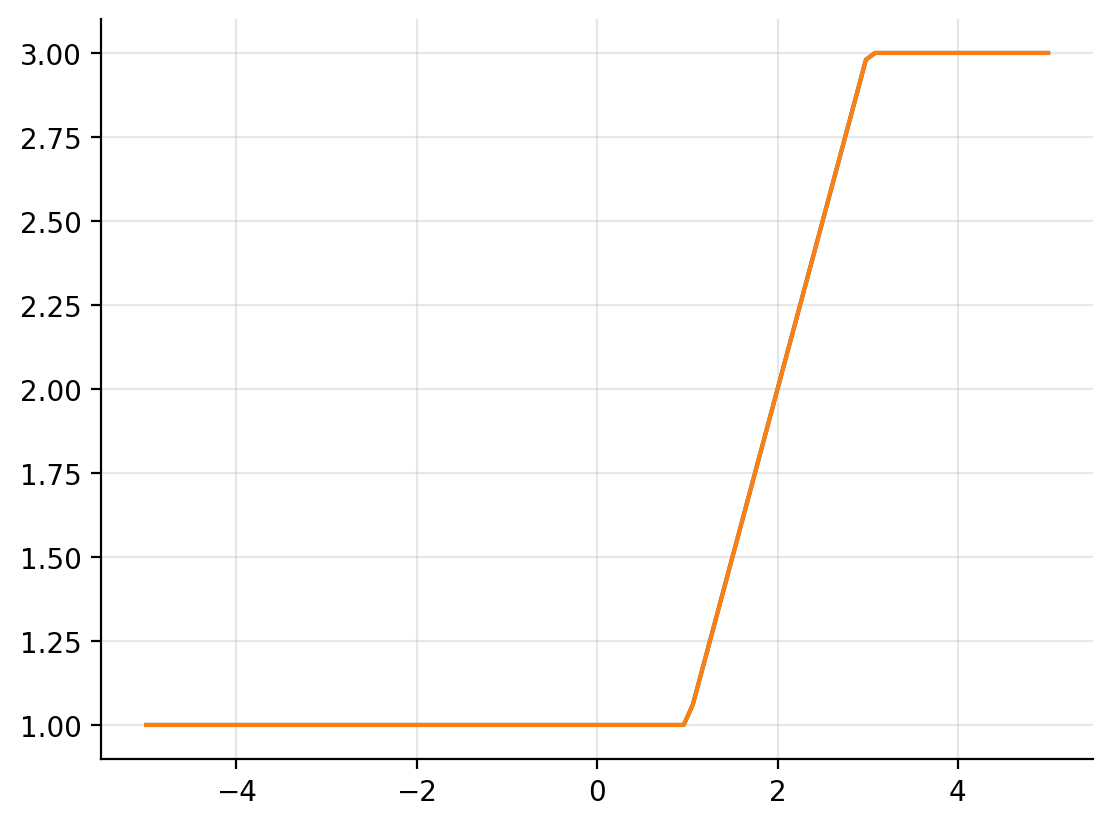

In [3]:
xv = jnp.linspace(-5, 5, 100)

def f(x, a, b):
    return jnp.minimum(jnp.maximum(x, a), b)
    
def fprime(x, a, b):
    return jnp.clip(x, a, b)
    
plt.plot(xv, f(xv, 1, 3))
plt.plot(xv, fprime(xv, 1, 3))
plt.grid(alpha=0.3)

In [4]:
# Discount rate
γ = 0.9
# Rate of request
λ_req_a, λ_req_b = 3, 4
# Rate of return
λ_ret_a, λ_ret_b = 3, 2

# Maximum number of cars allowed at any location
max_cars = 20
# Maximum number of cars that are allowed to be moved overnight
max_car_move = 5

# MDP:
# timestep: days
# state: number of cars at each location at the end of the day
# actions: net number of cars moved between the two locations overnight

In [5]:
def update_location_a(s_prev, n_ret, n_req, k):
    """
    State in location a at the end of day t+1
    having moved k cars overnight from location a to location b
    """
    s_next = s_prev - k - n_req + n_ret
    s_next = jnp.clip(s_next + n_ret, n_ret, n_max)
    return s_next


def update_location_b(s_prev, n_ret, n_req, k):
    """
    State in location b at the end of day t+1
    having moved k cars overnight from location a to location b
    """
    s_next = s_prev + k - n_req + n_ret
    s_next = jnp.clip(s_next + n_ret, n_ret, n_max)
    return s_next


def pr_transition_a(n_ret, n_req):
    """
    Probability of transition at location a
    is given by the probability of returns
    times the probability of requests
    """
    p_ret = poisson.pmf(n_ret,  λ_ret_a)
    p_req = poisson.pmf(n_req, λ_req_a)
    return p_ret * p_req


def pr_transition_b(n_ret, n_req):
    p_ret = poisson.pmf(n_ret, λ_ret_b)
    p_req = poisson.pmf(n_req, λ_req_b)
    return p_ret * p_req

In [7]:
@partial(jax.vmap, in_axes=(None, None, 0, None, None, None, None, None))
@partial(jax.vmap, in_axes=(None, None, None, 0, None, None, None, None))
@partial(jax.vmap, in_axes=(None, None, None, None, 0, None, None, None))
@partial(jax.vmap, in_axes=(None, None, None, None, None, 0, None, None))
def prob_val_state(
    n_a,
    n_b,
    n_ret_a,
    n_ret_b,
    n_req_a,
    n_req_b,
    action,
    value_function
):
    """
    Element of (proba x value) used to evaluate the value function of a policy
    
    Params
    ------
    n_a: number of cars at location a (start of day)
    n_ret_a: number of cars returns to location a (end of day)
    n_req_a: number of cars requested at location a (during day)
    
    n_b: number of cars at location b (start of day)
    n_ret_b: number of cars returned to location b (end of day)
    n_req_b: number of cars requested at location b
    
    action: number of cars moved from a to b overnight
    """
    
                                                
    n_a_prime = n_a - action
    n_b_prime = n_b + action

    n_req_a = jnp.minimum(n_a_prime, n_req_a)
    n_req_b = jnp.minimum(n_b_prime, n_req_b)

    n_a_prime = n_a_prime + n_ret_a - n_req_a
    n_b_prime = n_b_prime + n_ret_b - n_req_b

    n_a_prime = jnp.clip(n_a_prime, 0, 20)
    n_b_prime = jnp.clip(n_b_prime, 0, 20)

    
    # n_a_prime = jnp.clip(n_a - action - n_req_a + n_ret_a, 0, max_cars)
    # n_b_prime = jnp.clip(n_b + action - n_req_b + n_ret_b, 0, max_cars)
    
    pr_a = pr_transition_a(n_ret_a, n_req_a)
    pr_b = pr_transition_b(n_ret_b, n_req_b)
    
    pr =  pr_a * pr_b
    val = 10 * (n_req_a + n_req_b) + γ * value_function[n_a_prime, n_b_prime]
    return pr * val


def action_value_function(n_a, n_b, value_function, action):
    elements = jnp.arange(max_cars)
    probs_vals = prob_val_state(
        n_a, n_b,
        elements, elements, elements, elements,
        action, value_function
    )
    is_valid_state = (action <= n_a) * (action >= -n_b)
    vfun = (probs_vals.sum() - 2 * jnp.abs(action)) * is_valid_state
    return vfun


@jax.jit
def value_function(n_a, n_b, value_function, policy):
    action = policy[n_a, n_b]
    return action_value_function(n_a, n_b, value_function, action)


@jax.jit
def max_action_value_function(n_a, n_b, value_function, actions):
    vf = jax.vmap(action_value_function, in_axes=(None, None, None, 0))
    return vf(n_a, n_b, value_function, actions).argmax() - max_car_move


xvalue_function = jax.vmap(value_function, in_axes=(0, None, None, None))
xvalue_function = jax.vmap(xvalue_function, in_axes=(None, 0, None, None))
xvalue_function = jax.jit(xvalue_function)


@jax.jit
def xaction_value_function(states_a, states_b, value_function, actions):
    """
    Vmap over states_b and lax.map over states_a for memory-efficient
    policy update
    """
    vf = jax.vmap(max_action_value_function, in_axes=(None, 0, None, None), out_axes=-1)
    def part(X):
        return vf(X, states_b, value_function, actions)
    return jax.lax.map(part, states_a)


def policy_evaluate(val, states_a, states_b, policy, eps):
    value_function, delta_old, i = val
    updated_value_function = xvalue_function(states_a, states_b, value_function, policy)
    
    delta_value = jnp.abs(updated_value_function / (value_function + eps) - 1).max()
    
    val_new = updated_value_function, delta_value, i + 1
    return val_new


@jax.jit
def policy_iterate(states_a, states_b, value_function, policy, max_err=1.0, eps=1e-6, max_iter=100):
    partial_eval = partial(policy_evaluate,
        states_a=states_a, states_b=states_b, policy=policy, eps=eps
    )
    err_init = 100
    init_val = (value_function, err_init, 0.0)
    def cond(val): return jnp.logical_and(val[1] > max_err, val[2] < max_iter)
    # def cond(val): return val[2] < max_iter
    
    (value_final, max_err, itot) = jax.lax.while_loop(
        cond, partial_eval, init_val
    )
    return value_final, max_err, itot

In [8]:
actions = jnp.arange(-5, 6)
states = jnp.arange(max_cars + 1)

value_grid = jnp.zeros((max_cars + 1, max_cars + 1))
# policy = jnp.zeros((2 * max_car_move + 1, max_cars + 1, max_cars + 1))
# # Start by moving no cars at all
# n_move = 0 # can take -5 to 5 value
# policy = policy.at[n_move + max_car_move].set(1)
policy = jnp.zeros((max_cars + 1, max_cars + 1)).astype(int)

In [9]:
jax.vmap(action_value_function, in_axes=(None, None, None, 0))(20, 1, value_grid, actions)

Array([  0.      ,   0.      ,   0.      ,   0.      ,   8.992761,  56.24613 , 133.39845 ,
       206.09552 , 235.41731 , 215.79153 , 170.03316 ], dtype=float32)

In [10]:
%%time
value_grid = xvalue_function(states, states, value_grid, policy)
value_function(20, 1, value_grid, policy)

CPU times: user 4.34 s, sys: 30.5 ms, total: 4.37 s
Wall time: 2.25 s


Array(306.17395, dtype=float32)

In [23]:
(value_grid, err, it) = policy_iterate(
    states, states, value_grid, policy,
    max_iter=10
)
value_grid = jax.block_until_ready(value_grid)

In [24]:
it

Array(10., dtype=float32, weak_type=True)

In [25]:
value_function(20, 1, value_grid, policy)

Array(4.310818e+26, dtype=float32)

In [ ]:
%%time
policy = xaction_value_function(states, states, value_grid, actions)
policy = jax.block_until_ready(policy)

In [ ]:
policy

<Axes: >

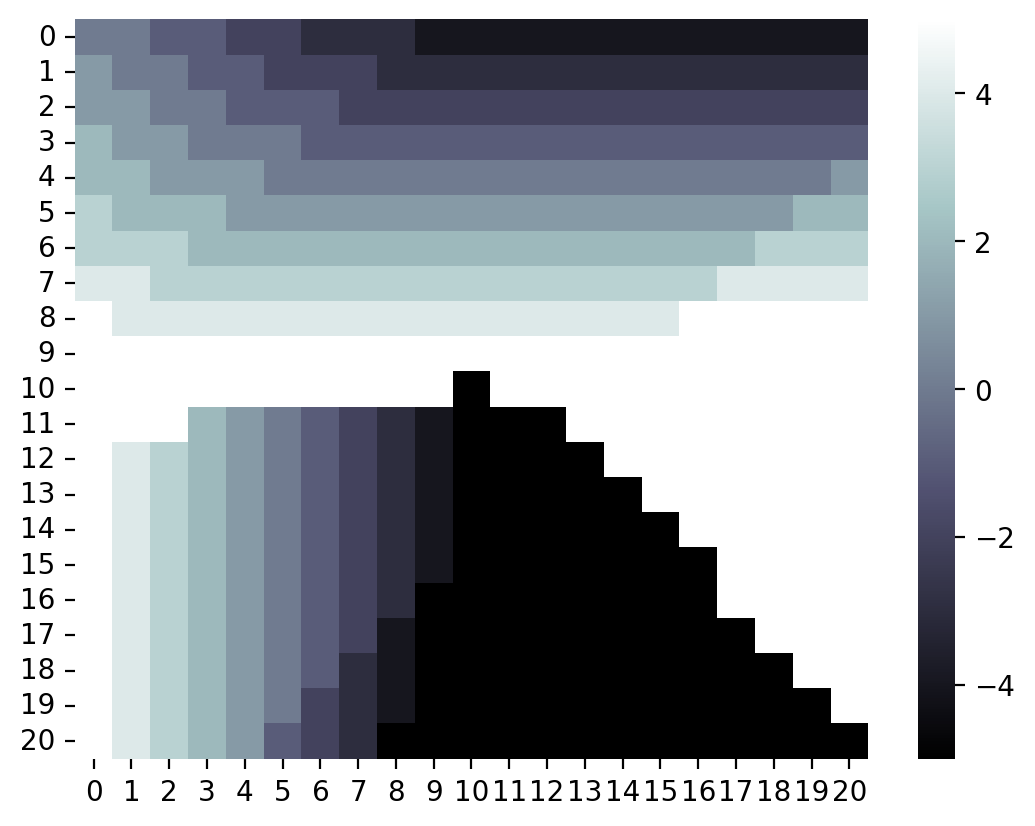

In [22]:
sns.heatmap(policy, cmap="bone")

## Old stuff

In [40]:
value_grid = jnp.zeros((max_cars + 1, max_cars + 1))
policy = jnp.zeros((2 * max_car_move + 1, max_cars + 1, max_cars + 1))

# Start with moving no cars
n_move = 0 + 5
policy = policy.at[5].set(1)


In [5]:
max_elements = 20
discount = 0.9

@jax.jit
def value_function(state, action_array, value_grid, discount):
    state_a, state_b = state
    action = action_array.argmax() - 5
    
    action_clipped = jnp.clip(action, -state_b, state_a)
    is_valid_action = action == action_clipped
    
    with loops.Scope() as s:
        # cost of moving cars overnight
        s.expected_reward = -2.0 * jnp.abs(action)
        
        for n_ret_a in s.range(max_elements):
            for n_req_a in s.range(max_elements):
                for n_ret_b in s.range(max_elements):
                    for n_req_b in s.range(max_elements):
                        
                        pr = pr_transition_a(n_ret_a, n_req_a) * pr_transition_b(n_ret_b, n_req_b)
                                                
                        sa_prime = state_a - action
                        sb_prime = state_b + action
                        
                        n_req_a = jnp.minimum(sa_prime, n_req_a)
                        n_req_b = jnp.minimum(sb_prime, n_req_b)
                                                
                        sa_prime = sa_prime + n_ret_a - n_req_a
                        sb_prime = sb_prime + n_ret_b - n_req_b
                        
                        sa_prime = jnp.clip(sa_prime, 0, 20)
                        sb_prime = jnp.clip(sb_prime, 0, 20)

                        reward = 10.0 * (n_req_a + n_req_b)
                            
                        value_config = reward + discount * value_grid[sa_prime, sb_prime]
                        s.expected_reward += pr * value_config
                        
    return s.expected_reward * is_valid_action

In [6]:
vmap_value_function = jax.vmap(value_function, (1, 1, None, None), out_axes=0)
vmap_value_function = jax.vmap(vmap_value_function, (2, 2, None, None), out_axes=1)

In [7]:
improv_value_function = jax.vmap(value_function, (1, None, None, None), out_axes=0)
improv_value_function = jax.vmap(improv_value_function, (2, None, None, None), out_axes=1)
improv_value_function = jax.vmap(improv_value_function, (None, 0, None, None), out_axes=2)

## Iteration

In [8]:
# ** Initial policy **
# In the initial policy we assume that we will not be moving
# cars between lots
policy = jnp.zeros((11, 21, 21)) # (action, sa, sb)
policy = policy.at[5].set(1)
value_array = jnp.zeros((21, 21))
vrange = jnp.mgrid[:21, :21]
discount = 0.9
arange_ix = jnp.eye(11).astype(int) # Fixed array to pass to the policy-improvement scheme

In [9]:
@jax.jit
def update(value_array, policy, discount, max_err=0.1, eps=1e-6):
    with loops.Scope() as s:
        s.value_array = value_array
        s.err = max_err + 1.0
        s.ix = 0
        for _ in s.while_range(lambda: s.err > max_err):
            update_value_array = vmap_value_function(vrange, policy, s.value_array, discount)
            s.err = jnp.abs(update_value_array / (s.value_array + eps) - 1).max()
            s.value_array = update_value_array
            s.ix += 1
    return s.ix, s.value_array

In [10]:
threshold = 0.95
value_array = jnp.zeros((21, 21))
policy_ix = jnp.zeros((21, 21))
policy_hist = []

In [11]:
ix = 0
is_stable = False
policy_hist_ix = []
threshold = 0.95

while not is_stable:
    print(f"it: {ix+1:02}")
    nsteps, value_array = update(value_array, policy, discount)
    q_improv = improv_value_function(vrange, arange_ix, value_array, discount).block_until_ready()
    curr_threshold = (policy_ix == q_improv.argmax(axis=-1)).mean().item()
    is_stable = curr_threshold >= threshold
    policy_ix = q_improv.argmax(axis=-1)
    policy = jnp.transpose(jax.nn.one_hot(policy_ix, 11), (2, 0, 1))
    print(f"threshold: {curr_threshold:0.2%}", end="\n\n")
    policy_hist_ix.append(policy_ix)
    ix += 1

it: 01
threshold: 0.00%

it: 02
threshold: 38.78%

it: 03
threshold: 87.76%

it: 04
threshold: 97.73%



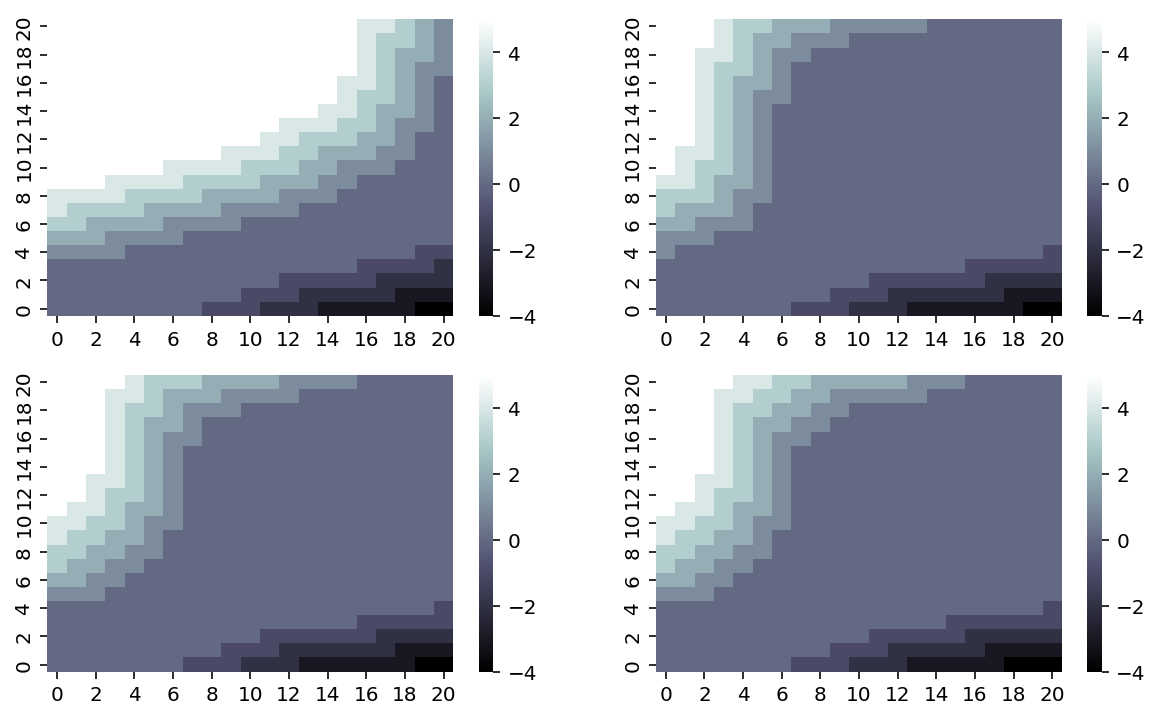

In [12]:
policy_hist = jnp.stack(policy_hist_ix, axis=0) - 5
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.ravel()
for axi, policy_i in zip(ax, policy_hist):
    sns.heatmap(policy_i, ax=axi, cbar=True, cmap="bone")
    axi.invert_yaxis()

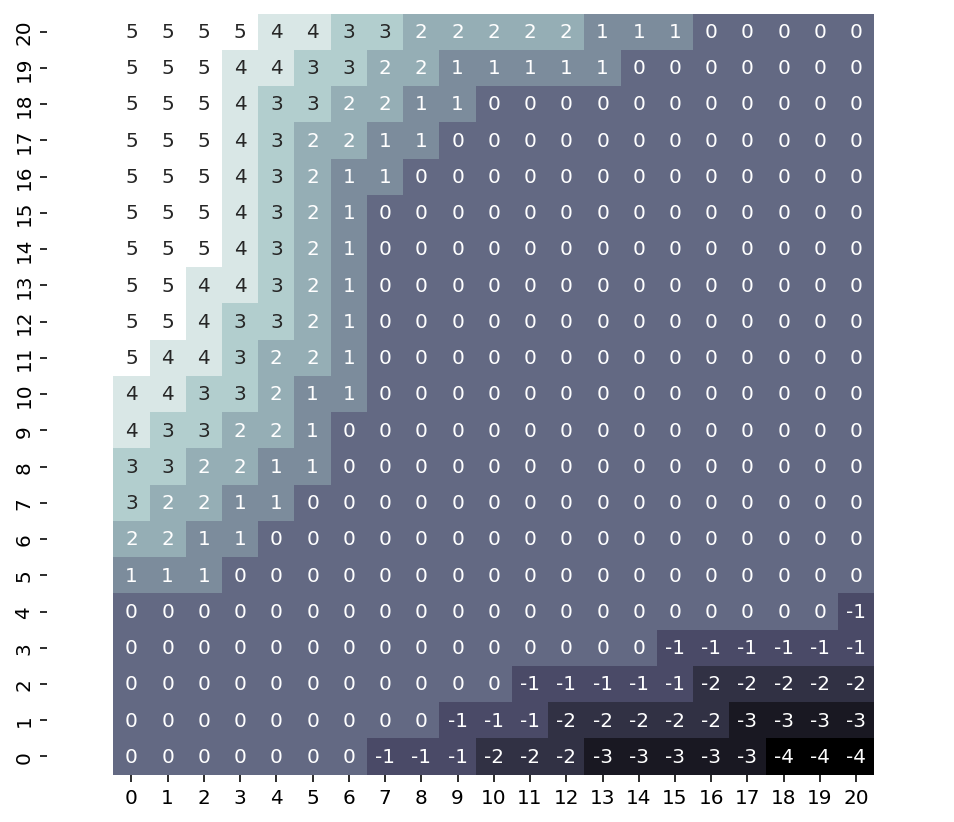

In [13]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(policy_hist[-1], cmap="bone", cbar=False, ax=ax, annot=True)
ax.axis("equal")
ax.invert_yaxis()

# References

* https://towardsdatascience.com/elucidating-policy-iteration-in-reinforcement-learning-jacks-car-rental-problem-d41b34c8aec7
* https://jax.readthedocs.io/en/latest/jax.experimental.loops.html